In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import math
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from flash_attn import flash_attn_func
from xgboost import XGBRegressor, DMatrix
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

from kneed import KneeLocator
from collections import defaultdict

from gpu_pca import IncrementalPCAonGPU

# 自訂模組
from library import StockUniverse, FactorLibrary, MarketInfo, FileLoader, FactorLibrary2

📂 讀取: Y:\因子回測_江建彰\因子庫.pkl


In [2]:
stock_universe = 'TWSE'
flib = FactorLibrary2(path=f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')

📂 讀取: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [3]:
class AllDayFactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE'):
        self.multi_df = FileLoader.load(f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')
        self.adj_close_df = pd.read_feather(r'Y:\因子回測_江建彰\補上缺值日頻收盤價.ftr')
        self.stock_list = self.get_stock_list(stock_universe)
        
        self.TPEX_df = MarketInfo.TPEX_norm()
        self.RoR_df = (self.adj_close_df.shift(-5) - self.adj_close_df.shift(-1)) / self.adj_close_df.shift(-1)
        self.RoR_df.dropna(axis=0, inplace=True)


        new_ticker_list = self.multi_df.columns.get_level_values('ticker')
        new_ticker_list = new_ticker_list[~new_ticker_list.duplicated()]

        self.stock_list = new_ticker_list
        self.RoR_df = self.RoR_df[self.stock_list]
        self.adj_close_df = self.adj_close_df[self.stock_list]
        # 這裡所有值都包含當天資訊所以要向後移
        self.restrict_range()
        self.check_validility()

    def check_validility(self):
        ticker_list1 = self.stock_list
        ticker_list2 = self.RoR_df.columns
        ticker_list3 = self.multi_df.columns.get_level_values('ticker')
        ticker_list3 = ticker_list3[~ticker_list3.duplicated()]
        assert len(ticker_list1)==len(ticker_list2)==len(ticker_list3)
        
        BOOL = True
        for i in range(len(ticker_list1)):
            if not (ticker_list1[i]==ticker_list2[i]==ticker_list3[i]):
                BOOL = False
        assert BOOL==True
        

        factor_list = self.multi_df.columns.get_level_values('factor')
        factor_list = factor_list[~factor_list.duplicated()]
        BOOL = True
        for factor_name in factor_list:
            ticker_list4 = self.multi_df.loc[ : , factor_name].columns
            for i in range(len(ticker_list1)):
                if ticker_list1[i]!=ticker_list4[i]:
                    BOOL = False
        assert BOOL==True
        
    

    def restrict_range(self, global_start='2020-04-01', global_end='2025-04-09'):
        self.multi_df     = self.multi_df.loc[global_start : global_end]
        self.adj_close_df = self.adj_close_df.loc[global_start : global_end]
        self.TPEX_df      = self.TPEX_df.loc[global_start : global_end]
        self.RoR_df       = self.RoR_df.loc[global_start : global_end]
    
        
        
        
    def get_stock_list(self, stock_univserse):
        if stock_univserse=='TWSE':
            ticker1 = StockUniverse.TWSE() 
        elif stock_univserse=='OTC':
            ticker1 = StockUniverse.OTC()
        elif stock_univserse=='all':
            ticker1 = StockUniverse.all()
            
        
        ticker2 = self.multi_df.columns.get_level_values('ticker')
        ticker3 = self.adj_close_df.columns
        return list(set(ticker1)&set(ticker2)&set(ticker3))


    

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
factor_dataset = AllDayFactorDataset(stock_universe='TWSE')

⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [5]:
RoR_df = factor_dataset.RoR_df
z_return_df = (RoR_df - RoR_df.mean(axis=1).values[:, None]) / RoR_df.std(axis=1).values[:, None]

In [6]:
factor_dataset.multi_df

factor      factor_0                                                    \
ticker          1101      1102      1103      1104      1108      1109   
Date                                                                     
2020-04-01 -0.673939 -0.455914 -0.600366 -0.193277  1.754857 -0.967506   
2020-04-06 -0.327203 -0.146773 -0.556454 -0.166725  1.027622 -0.758691   
2020-04-07  0.098016  1.224380  0.101407  0.234013  0.153450 -0.239635   
2020-04-08 -0.319991  0.674528  0.049169  0.289316 -0.621626 -0.291409   
2020-04-09 -0.232543  0.327937  0.066867  0.110226 -0.713421 -0.238935   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02  1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07  1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08  1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09  1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185            \
ticker          1110      1201      1203      1210  ...       9939      9940   
Date                                                ...                        
2020-04-01 -1.611826  1.346149 -0.139294  0.163777  ...   0.066802  0.072487   
2020-04-06 -2.130461 -0.347443 -1.021574 -0.870032  ...   0.082190  0.082626   
2020-04-07 -1.987577 -0.916866 -0.984516 -0.930563  ...   0.068940  0.073008   
2020-04-08 -1.360423 -0.868599 -0.781669 -0.766940  ...   0.055604  0.033972   
2020-04-09 -0.264998 -0.536980 -0.391901 -0.507913  ...   0.049386  0.022256   
...              ...       ...       ...       ...  ...        ...       ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...  -1.143642 -0.416881   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...  -0.992188  0.137274   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...  -0.008507  0.000583   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...  -0.027256 -0.034378   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...  -0.067628  0.004631   

factor                                                                  \
ticker          9941      9942      9943      9944      9945      9946   
Date                                                                     
2020-04-01  0.058731  0.070173  0.068826  0.072342  0.041585  0.107296   
2020-04-06  0.078126  0.092643  0.096279  0.101995  0.070161  0.119151   
2020-04-07  0.074640  0.075921  0.077645  0.111064  0.090337  0.051750   
2020-04-08  0.036535  0.031070  0.035563  0.098852  0.055969 -0.003307   
2020-04-09  0.040502  0.031352  0.046665  0.097971  0.031984  0.103135   
...              ...       ...       ...       ...       ...       ...   
2025-04-01 -0.168819  0.081369  0.144244  1.824791 -0.507640 -1.891102   
2025-04-02  1.358135  0.246138  0.452394  1.848424 -0.107221 -1.861662   
2025-04-07  0.073191  0.038328  0.005722  0.076073  0.036290  0.023162   
2025-04-08 -0.011736 -0.036078 -0.000374  0.047075  0.018541  0.000232   
2025-04-09 -0.126421 -0.091972 -0.039853 -0.126421 -0.023461 -0.007847   

factor                          
ticker          9955      9958  
Date                            
2020-04-01  0.074130  0.078821  
2020-04-06  0.100967  0.086217  
2020-04-07  0.089592  0.078324  
2020-04-08  0.017020  0.083563  
2020-04-09  0.003805  0.043055  
...              ...       ...  
2025-04-01  1.824791  0.835318  
2025-04-02  1.848424  1.022157  
2025-04-07  0.076073  0.074417  
2025-04-08  0.104005  0.104005  
2025-04-09  0.156484  0.178677  

[1220 rows x 164982 columns]

In [7]:
z_return_df

symbol_id,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
trade_date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,-0.165141,0.396585,0.078443,0.089599,-0.619321,-0.148782,-0.933043,-0.686305,-0.901289,-0.731514,...,-0.416946,0.616390,0.865555,-0.155905,-0.268315,-1.961625,-1.344977,0.984428,0.483491,-0.488042
2020-04-06,-0.277162,0.299730,0.009240,0.353117,-0.010091,0.044924,0.815303,-0.652765,-0.360477,-0.378793,...,-0.460243,0.036481,0.434861,-0.045912,0.179594,-0.824940,-0.726843,3.296798,0.899926,-0.943563
2020-04-07,-0.386795,-0.370135,-0.196156,0.088294,0.371439,-0.151109,0.292804,-0.508770,-0.557872,0.005393,...,-0.385102,-0.630818,0.216666,-0.017604,-0.245133,-1.081967,-0.760730,1.611201,1.893717,-1.222098
2020-04-08,-0.337903,-0.311649,0.183218,-0.299780,0.037332,-0.164683,-0.697732,-0.454069,-0.728089,0.217207,...,-0.521642,-0.991485,0.152767,0.299659,0.876070,-1.256489,-0.638734,0.623656,1.738175,-0.584666
2020-04-09,-0.309666,-0.202460,-0.103384,-0.248170,0.039149,-0.059893,-0.340883,-0.429343,-0.537162,0.121838,...,-0.527237,-1.149834,-0.385602,0.331072,1.192523,-0.723895,-0.482876,0.157595,0.957960,-0.913058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,1.402303,1.502139,1.127752,1.433449,1.246867,1.440701,1.367405,1.270386,2.186734,1.630942,...,1.727693,1.844437,0.736191,1.195100,1.699285,-0.427417,0.635624,-0.805535,-0.804724,-0.851156
2025-04-02,0.691778,1.509598,0.995400,1.080868,1.191060,1.187973,0.226545,0.860312,2.288222,1.404747,...,1.320865,1.150398,1.312095,0.869575,1.440482,-0.532895,0.617429,-1.453804,-0.249547,-0.339102
2025-04-07,-0.513137,-0.020134,0.020299,-0.345851,0.241752,-0.180007,-0.681870,-0.986001,0.524322,-0.283805,...,-0.341533,-0.537381,0.948872,0.289577,-0.466110,-1.111572,-0.524792,-1.388810,0.199153,2.128009


In [82]:
# ---------- 共用基底類別 ----------

class BaseFeatureSelector:
    def _knee_select(self, scores_sorted):
        x = list(range(len(scores_sorted)))
        y_score = scores_sorted.values
        kn = KneeLocator(x, y_score, curve="convex", direction="decreasing")
        elbow_idx = kn.knee if kn.knee is not None else 10  # fallback 預設選前10個
        return scores_sorted.iloc[:elbow_idx].index.tolist()


class FRegressionFeatureSelector(BaseFeatureSelector):
    def select(self, model, X, y):
        f_scores, _ = f_regression(X, y)
        scores = pd.Series(f_scores, index=X.columns).fillna(0)
        scores_sorted = scores.sort_values(ascending=False)
        return self._knee_select(scores_sorted)



# ---------- 模型訓練主類別 ----------

class XGBRegression:
    def __init__(self, X_train, X_val, y_train, feature_selector):
        self.X_train_full = X_train
        self.X_val_full = X_val
        self.y_train = y_train
        self.feature_selector = feature_selector

        # 若是 XGB 型特徵選擇器，需要先訓練模型
        pre_model = self._fit_model(X_train, y_train)

        # 特徵選擇
        self.top_features = self.feature_selector.select(pre_model, X_train, y_train)

        # 用選出的特徵重新訓練模型
        self.model = self._fit_model(X_train[self.top_features], y_train)

        # 計算驗證損失
        self.y_pred = self.model.predict(self.X_val_full[self.top_features])

    def _fit_model(self, X, y):
        model = XGBRegressor(
            tree_method="hist",
            device="cuda",
            n_estimators=100,
            learning_rate=0.05,
            max_depth=6,
            random_state=42
        )
        model.fit(X, y)
        return model





In [83]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import TimeSeriesSplit

class PCAPreprocessor:
    def __init__(self, explained_var_threshold=0.99):
        #self.a = None
        self.explained_var_threshold = explained_var_threshold
        

    def get_multidf_shift(self, n, multi_df):
        new_columns = [(f"{fac}_shift{n}", tic) for fac, tic in multi_df.columns]
        shifted = multi_df.copy()
        shifted.columns = pd.MultiIndex.from_tuples(new_columns, names=["factor", "ticker"])
        return shifted.shift(n)

    def get_all_multidf_shift(self, multi_df):
        shifts = [self.get_multidf_shift(i, multi_df.copy()) for i in range(0, 9)]
        all_shifted = pd.concat(shifts, axis=1).dropna(axis=0, how='any')
        return all_shifted

    def fit_pca(self, X, n_components):
        from gpu_pca import IncrementalPCAonGPU
        model = IncrementalPCAonGPU(n_components=n_components)
        model.fit(X)
        return model

    def reduce_dimension(self, model, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(model.device)
        reduced = model.transform(X_tensor).cpu().detach().numpy()
        return reduced

    def prepare_pca_dataframe(self, df_flat, reduced_X, index_99):
        f_col_names = [f'PCA_factor_{j}' for j in range(index_99)]
        df = pd.DataFrame(columns=['Date', 'ticker'] + f_col_names)
        df['Date'] = df_flat['Date']
        df['ticker'] = df_flat['ticker']
        df[f_col_names] = reduced_X
        return df.pivot(index='Date', columns='ticker')

    def process_fold(self, i, train_idx, val_idx, factor_dataset, z_return_df):
        # 補強資料
        val_idx = list(range(val_idx[0] - 8, val_idx[-1] + 1))

        df_flat_train = (factor_dataset.multi_df.iloc[train_idx]
            .stack(level='ticker', future_stack=True)
            .reset_index()
            .sort_values(by=['Date', 'ticker'])
        )

        df_flat_val = (factor_dataset.multi_df.iloc[val_idx]
            .stack(level='ticker', future_stack=True)
            .reset_index()
            .sort_values(by=['Date', 'ticker'])
        )

        X_train = df_flat_train.drop(columns=['Date', 'ticker']).values
        X_val = df_flat_val.drop(columns=['Date', 'ticker']).values

        model_full = self.fit_pca(X_train, n_components=X_train.shape[1])
        ratios = model_full.explained_variance_ratio_.cpu().numpy()
        cum_ratios = np.cumsum(ratios) / np.sum(ratios)
        index_99 = np.argmax(cum_ratios > self.explained_var_threshold) + 1

        print(f'篩選出{index_99}個PCA特徵')

        model_n = self.fit_pca(X_train, n_components=index_99)
        X_train_reduced = self.reduce_dimension(model_n, X_train)
        X_val_reduced = self.reduce_dimension(model_n, X_val)

        pca_multidf_train = self.prepare_pca_dataframe(df_flat_train, X_train_reduced, index_99)
        pca_multidf_val = self.prepare_pca_dataframe(df_flat_val, X_val_reduced, index_99)

        pca_multidf_val = pca_multidf_val.shift(1).iloc[1:]
        #print('pca_multidf_val')
        #print(pca_multidf_val)
        #self.a = pca_multidf_val

        all_multidf_train = self.get_all_multidf_shift(pca_multidf_train)
        all_multidf_val = self.get_all_multidf_shift(pca_multidf_val)

        train_stacked = (all_multidf_train.stack(level='ticker', future_stack=True)
            .reset_index()
            .sort_values(by=['Date', 'ticker'])
            .drop(columns=['Date', 'ticker']))

        start_dt, end_dt = all_multidf_train.index[0], all_multidf_train.index[-1]
        r_train_array = z_return_df.loc[start_dt:end_dt].stack().sort_index().values

        val_stacked = (all_multidf_val.stack(level='ticker', future_stack=True)
            .reset_index()
            .sort_values(by=['Date', 'ticker'])
            #.drop(columns=['Date', 'ticker'])
        )

        self.a = val_stacked

        #start_dt_val, end_dt_val = all_multidf_val.index[0], all_multidf_val.index[-1]
        #r_val_array = z_return_df.loc[start_dt_val:end_dt_val].stack().sort_index().values


        return train_stacked, r_train_array, val_stacked


In [178]:
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import TimeSeriesSplit
from gpu_pca import IncrementalPCAonGPU

class PCAPreprocessor:
    def __init__(self, explained_var_threshold=0.99, use_kernel_pca=False, kernel="rbf", gamma=0.1):
        self.explained_var_threshold = explained_var_threshold
        self.use_kernel_pca = use_kernel_pca
        self.kernel = kernel
        self.gamma = gamma

    def get_multidf_shift(self, n, multi_df):
        new_columns = [(f"{fac}_shift{n}", tic) for fac, tic in multi_df.columns]
        shifted = multi_df.copy()
        shifted.columns = pd.MultiIndex.from_tuples(new_columns, names=["factor", "ticker"])
        return shifted.shift(n)

    def get_all_multidf_shift(self, multi_df):
        shifts = [self.get_multidf_shift(i, multi_df.copy()) for i in range(0, 9)]
        all_shifted = pd.concat(shifts, axis=1).dropna(axis=0, how='any')
        return all_shifted

    def fit_pca(self, X, n_components):
        if self.use_kernel_pca:
            model = KernelPCA(n_components=n_components, kernel=self.kernel, gamma=self.gamma, fit_inverse_transform=False)
            X_reduced = model.fit_transform(X)
            return model, X_reduced
        else:
            model = IncrementalPCAonGPU(n_components=n_components)
            model.fit(X)
            return model, None

    def reduce_dimension(self, model, X, X_reduced=None):
        if self.use_kernel_pca:
            return X_reduced
        else:
            X_tensor = torch.tensor(X, dtype=torch.float32).to(model.device)
            reduced = model.transform(X_tensor).cpu().detach().numpy()
            return reduced

    def prepare_pca_dataframe(self, df_flat, reduced_X, n_components):
        f_col_names = [f'PCA_factor_{j}' for j in range(n_components)]
        df = pd.DataFrame(columns=['Date', 'ticker'] + f_col_names)
        df['Date'] = df_flat['Date']
        df['ticker'] = df_flat['ticker']
        df[f_col_names] = reduced_X
        return df.pivot(index='Date', columns='ticker')

    def process_fold(self, i, train_idx, val_idx, factor_dataset, z_return_df):
        val_idx = list(range(val_idx[0] - 8, val_idx[-1] + 1))

        df_flat_train = (factor_dataset.multi_df.iloc[train_idx]
                         .stack(level='ticker', future_stack=True)
                         .reset_index()
                         .sort_values(by=['Date', 'ticker']))

        df_flat_val = (factor_dataset.multi_df.iloc[val_idx]
                       .stack(level='ticker', future_stack=True)
                       .reset_index()
                       .sort_values(by=['Date', 'ticker']))

        X_train = df_flat_train.drop(columns=['Date', 'ticker']).values
        X_val = df_flat_val.drop(columns=['Date', 'ticker']).values

        model_full, X_train_full_reduced = self.fit_pca(X_train, n_components=X_train.shape[1])

        if not self.use_kernel_pca:
            ratios = model_full.explained_variance_ratio_.cpu().numpy()
            cum_ratios = np.cumsum(ratios) / np.sum(ratios)
            index_99 = np.argmax(cum_ratios > self.explained_var_threshold) + 1
            print(f'篩選出{index_99}個PCA特徵')
            model_n, _ = self.fit_pca(X_train, n_components=index_99)
            X_train_reduced = self.reduce_dimension(model_n, X_train)
            X_val_reduced = self.reduce_dimension(model_n, X_val)
        else:
            # Kernel PCA 沒有 explained_variance_ratio_，直接用預設主成分數
            index_99 = X_train_full_reduced.shape[1]
            print(f'使用 Kernel PCA：{index_99} 個特徵')
            X_train_reduced = X_train_full_reduced
            X_val_reduced = self.reduce_dimension(None, X_val, X_reduced=model_full.transform(X_val))

        pca_multidf_train = self.prepare_pca_dataframe(df_flat_train, X_train_reduced, index_99)
        pca_multidf_val = self.prepare_pca_dataframe(df_flat_val, X_val_reduced, index_99)

        pca_multidf_val = pca_multidf_val.shift(1).iloc[1:]

        all_multidf_train = self.get_all_multidf_shift(pca_multidf_train)
        all_multidf_val = self.get_all_multidf_shift(pca_multidf_val)

        train_stacked = (all_multidf_train.stack(level='ticker', future_stack=True)
                         .reset_index()
                         .sort_values(by=['Date', 'ticker'])
                         .drop(columns=['Date', 'ticker']))

        start_dt, end_dt = all_multidf_train.index[0], all_multidf_train.index[-1]
        r_train_array = z_return_df.loc[start_dt:end_dt].stack().sort_index().values

        val_stacked = (all_multidf_val.stack(level='ticker', future_stack=True)
                       .reset_index()
                       .sort_values(by=['Date', 'ticker']))

        return train_stacked, r_train_array, val_stacked


In [203]:
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import KernelPCA, PCA
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import TimeSeriesSplit
from gpu_pca import IncrementalPCAonGPU

class PCAPreprocessor:
    def __init__(self, explained_var_threshold=0.99, use_kernel_pca=False, kernel="rbf", gamma=0.1, use_nystroem=False, nystroem_components=100):
        self.explained_var_threshold = explained_var_threshold
        self.use_kernel_pca = use_kernel_pca
        self.use_nystroem = use_nystroem
        self.kernel = kernel
        self.gamma = gamma
        self.nystroem_components = nystroem_components

    def get_multidf_shift(self, n, multi_df):
        new_columns = [(f"{fac}_shift{n}", tic) for fac, tic in multi_df.columns]
        shifted = multi_df.copy()
        shifted.columns = pd.MultiIndex.from_tuples(new_columns, names=["factor", "ticker"])
        return shifted.shift(n)

    def get_all_multidf_shift(self, multi_df):
        shifts = [self.get_multidf_shift(i, multi_df.copy()) for i in range(0, 9)]
        all_shifted = pd.concat(shifts, axis=1).dropna(axis=0, how='any')
        return all_shifted

    def fit_pca(self, X, n_components):
        if self.use_kernel_pca:
            if self.use_nystroem:
                nystroem = Nystroem(kernel=self.kernel, gamma=self.gamma, n_components=self.nystroem_components)
                X_approx = nystroem.fit_transform(X)
                model = PCA(n_components=n_components)
                X_reduced = model.fit_transform(X_approx)
                return (nystroem, model), X_reduced
            else:
                model = KernelPCA(n_components=n_components, kernel=self.kernel, gamma=self.gamma, fit_inverse_transform=False)
                X_reduced = model.fit_transform(X)
                return model, X_reduced
        else:
            model = IncrementalPCAonGPU(n_components=n_components)
            model.fit(X)
            return model, None

    def reduce_dimension(self, model, X, X_reduced=None):
        if self.use_kernel_pca:
            if self.use_nystroem:
                nystroem, pca_model = model
                X_approx = nystroem.transform(X)
                return pca_model.transform(X_approx)
            else:
                return X_reduced
        else:
            X_tensor = torch.tensor(X, dtype=torch.float32).to(model.device)
            reduced = model.transform(X_tensor).cpu().detach().numpy()
            return reduced

    def prepare_pca_dataframe(self, df_flat, reduced_X, n_components):
        f_col_names = [f'PCA_factor_{j}' for j in range(n_components)]
        df = pd.DataFrame(columns=['Date', 'ticker'] + f_col_names)
        df['Date'] = df_flat['Date']
        df['ticker'] = df_flat['ticker']
        df[f_col_names] = reduced_X
        return df.pivot(index='Date', columns='ticker')

    def process_fold(self, i, train_idx, val_idx, factor_dataset, z_return_df):
        val_idx = list(range(val_idx[0] - 8, val_idx[-1] + 1))

        df_flat_train = (factor_dataset.multi_df.iloc[train_idx]
                         .stack(level='ticker', future_stack=True)
                         .reset_index()
                         .sort_values(by=['Date', 'ticker']))

        df_flat_val = (factor_dataset.multi_df.iloc[val_idx]
                       .stack(level='ticker', future_stack=True)
                       .reset_index()
                       .sort_values(by=['Date', 'ticker']))

        X_train = df_flat_train.drop(columns=['Date', 'ticker']).values
        X_val = df_flat_val.drop(columns=['Date', 'ticker']).values

        model_full, X_train_full_reduced = self.fit_pca(X_train, n_components=X_train.shape[1])

        if not self.use_kernel_pca:
            ratios = model_full.explained_variance_ratio_.cpu().numpy()
            cum_ratios = np.cumsum(ratios) / np.sum(ratios)
            index_99 = np.argmax(cum_ratios > self.explained_var_threshold) + 1
            print(f'篩選出{index_99}個PCA特徵')
            model_n, _ = self.fit_pca(X_train, n_components=index_99)
            X_train_reduced = self.reduce_dimension(model_n, X_train)
            X_val_reduced = self.reduce_dimension(model_n, X_val)
        else:
            index_99 = X_train_full_reduced.shape[1]
            print(f'使用 {"Nystroem + PCA" if self.use_nystroem else "Kernel PCA"}：{index_99} 個特徵')
            X_train_reduced = X_train_full_reduced
            X_val_reduced = self.reduce_dimension(model_full, X_val)

        pca_multidf_train = self.prepare_pca_dataframe(df_flat_train, X_train_reduced, index_99)
        pca_multidf_val = self.prepare_pca_dataframe(df_flat_val, X_val_reduced, index_99)

        pca_multidf_val = pca_multidf_val.shift(1).iloc[1:]

        all_multidf_train = self.get_all_multidf_shift(pca_multidf_train)
        all_multidf_val = self.get_all_multidf_shift(pca_multidf_val)

        train_stacked = (all_multidf_train.stack(level='ticker', future_stack=True)
                         .reset_index()
                         .sort_values(by=['Date', 'ticker'])
                         .drop(columns=['Date', 'ticker']))

        start_dt, end_dt = all_multidf_train.index[0], all_multidf_train.index[-1]
        r_train_array = z_return_df.loc[start_dt:end_dt].stack().sort_index().values

        val_stacked = (all_multidf_val.stack(level='ticker', future_stack=True)
                       .reset_index()
                       .sort_values(by=['Date', 'ticker']))

        return train_stacked, r_train_array, val_stacked


In [204]:
factor_dataset.multi_df.loc['2024-09-20':].index

DatetimeIndex(['2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25',
               '2024-09-26', '2024-09-27', '2024-09-30', '2024-10-01',
               '2024-10-04', '2024-10-07',
               ...
               '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28',
               '2025-03-31', '2025-04-01', '2025-04-02', '2025-04-07',
               '2025-04-08', '2025-04-09'],
              dtype='datetime64[ns]', name='Date', length=129, freq=None)

In [205]:
factor_dataset.multi_df.loc['2024-12-20':].index

DatetimeIndex(['2024-12-20', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-30', '2024-12-31',
               '2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-13',
               '2025-01-14', '2025-01-15', '2025-01-16', '2025-01-17',
               '2025-01-20', '2025-01-21', '2025-01-22', '2025-02-03',
               '2025-02-04', '2025-02-05', '2025-02-06', '2025-02-07',
               '2025-02-10', '2025-02-11', '2025-02-12', '2025-02-13',
               '2025-02-14', '2025-02-17', '2025-02-18', '2025-02-19',
               '2025-02-20', '2025-02-21', '2025-02-24', '2025-02-25',
               '2025-02-26', '2025-02-27', '2025-03-03', '2025-03-04',
               '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-10',
               '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-14',
               '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20',
      

In [206]:
mask = factor_dataset.multi_df.index<='2020-04-12'
mask.nonzero()[0]

array([0, 1, 2, 3, 4, 5])

In [208]:
def correct_list(date_list, _type):
    new_date_list = []
    for _tuple in date_list:
        start, end = _tuple

        start, end = pd.Timestamp(start), pd.Timestamp(end)

        mask = factor_dataset.multi_df.index>=start
        start_idx = mask.nonzero()[0][0]

        mask = factor_dataset.multi_df.index<=end
        end_idx = mask.nonzero()[0][-1]

        start, end = factor_dataset.multi_df.index[start_idx], factor_dataset.multi_df.index[end_idx]
            
        #end_idx = factor_dataset.multi_df.index.get_loc(end)
        if _type=='train':
            end = factor_dataset.multi_df.index[end_idx-6]
        elif _type=='val':
            start = factor_dataset.multi_df.index[start_idx-1]
        
        new_date_list.append((start, end))

    return new_date_list
        

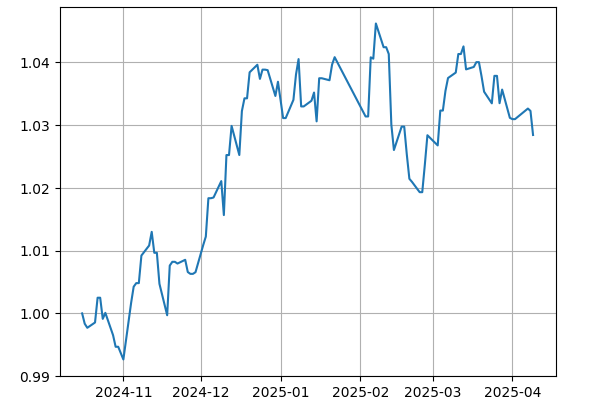

In [ ]:
"""
train_date_list = [('2020-04-01','2024-09-30'),('2020-05-01','2024-10-31'),('2020-06-01','2024-11-30'),
                   ('2020-07-01','2024-12-31'),('2020-08-01','2025-01-31'),('2020-09-01','2024-02-28'),
                   ('2020-10-01','2024-03-31')]


val_date_list = [('2024-10-01','2024-10-31'),('2024-11-01','2024-11-30'),('2024-12-01','2024-12-31'),
                 ('2025-01-01','2025-01-31'),('2025-02-01','2025-02-28'),('2025-03-01','2025-03-31'),
                 ('2025-04-01','2025-04-09')]
"""

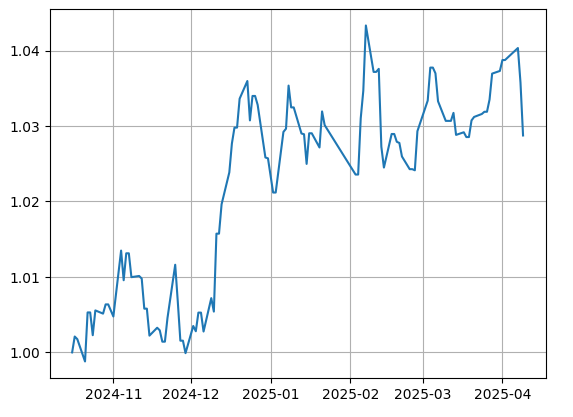

In [159]:
"""
train_date_list = [('2021-04-01','2024-09-30'),('2021-05-01','2024-10-31'),('2021-06-01','2024-11-30'),
                   ('2021-07-01','2024-12-31'),('2021-08-01','2025-01-31'),('2021-09-01','2024-02-28'),
                   ('2021-10-01','2024-03-31')]


val_date_list = [('2024-10-01','2024-10-31'),('2024-11-01','2024-11-30'),('2024-12-01','2024-12-31'),
                 ('2025-01-01','2025-01-31'),('2025-02-01','2025-02-28'),('2025-03-01','2025-03-31'),
                 ('2025-04-01','2025-04-09')]
"""

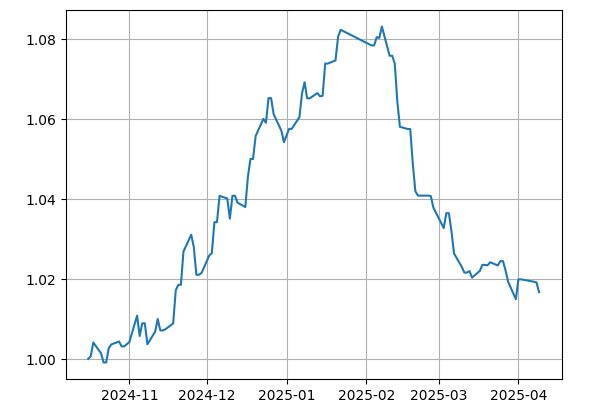

In [168]:
"""
train_date_list = [('2022-04-01','2024-09-30'),('2022-05-01','2024-10-31'),('2022-06-01','2024-11-30'),
                   ('2022-07-01','2024-12-31'),('2022-08-01','2025-01-31'),('2022-09-01','2024-02-28'),
                   ('2022-10-01','2024-03-31')]


val_date_list = [('2024-10-01','2024-10-31'),('2024-11-01','2024-11-30'),('2024-12-01','2024-12-31'),
                 ('2025-01-01','2025-01-31'),('2025-02-01','2025-02-28'),('2025-03-01','2025-03-31'),
                 ('2025-04-01','2025-04-09')]
"""

In [183]:
train_date_list = [('2022-04-01','2024-09-30'),('2022-05-01','2024-10-31'),('2022-06-01','2024-11-30'),
                   ('2022-07-01','2024-12-31'),('2022-08-01','2025-01-31'),('2022-09-01','2024-02-28'),
                   ('2022-10-01','2024-03-31')]


val_date_list = [('2024-10-01','2024-10-31'),('2024-11-01','2024-11-30'),('2024-12-01','2024-12-31'),
                 ('2025-01-01','2025-01-31'),('2025-02-01','2025-02-28'),('2025-03-01','2025-03-31'),
                 ('2025-04-01','2025-04-09')]

In [209]:
train_date_list = [('2020-04-01','2024-09-30'),('2020-05-01','2024-10-31'),('2020-06-01','2024-11-30'),
                   ('2020-07-01','2024-12-31'),('2020-08-01','2025-01-31'),('2020-09-01','2024-02-28'),
                   ('2020-10-01','2024-03-31')]


val_date_list = [('2024-10-01','2024-10-31'),('2024-11-01','2024-11-30'),('2024-12-01','2024-12-31'),
                 ('2025-01-01','2025-01-31'),('2025-02-01','2025-02-28'),('2025-03-01','2025-03-31'),
                 ('2025-04-01','2025-04-09')]

In [236]:
train_date_list = [('2023-04-01','2024-09-30'),('2023-05-01','2024-10-31'),('2023-06-01','2024-11-30'),
                   ('2023-07-01','2024-12-31'),('2023-08-01','2025-01-31'),('2023-09-01','2024-02-28'),
                   ('2023-10-01','2024-03-31')]


val_date_list = [('2024-10-01','2024-10-15'),('2024-11-01','2024-11-30'),('2024-12-01','2024-12-31'),
                 ('2025-01-01','2025-01-31'),('2025-02-01','2025-02-28'),('2025-03-01','2025-03-31'),
                 ('2025-04-01','2025-04-09')]

In [237]:
factor_dataset.multi_df.loc['2020-04-01':'2024-09-30']

factor      factor_0                                                    \
ticker          1101      1102      1103      1104      1108      1109   
Date                                                                     
2020-04-01 -0.673939 -0.455914 -0.600366 -0.193277  1.754857 -0.967506   
2020-04-06 -0.327203 -0.146773 -0.556454 -0.166725  1.027622 -0.758691   
2020-04-07  0.098016  1.224380  0.101407  0.234013  0.153450 -0.239635   
2020-04-08 -0.319991  0.674528  0.049169  0.289316 -0.621626 -0.291409   
2020-04-09 -0.232543  0.327937  0.066867  0.110226 -0.713421 -0.238935   
...              ...       ...       ...       ...       ...       ...   
2024-09-24  0.380083  0.530301  0.461203  0.124251 -0.248562 -0.486226   
2024-09-25  0.184525  1.050190  0.822259  0.344634  0.274468  0.001410   
2024-09-26  0.673940  0.790741  0.480277 -0.223601  0.153881  0.403090   
2024-09-27  1.863688  1.863688  0.278258  0.463391  0.609142  0.620713   
2024-09-30  1.301099  0.996658  0.153079 -0.206720  0.818073  0.463609   

factor                                              ... factor_185            \
ticker          1110      1201      1203      1210  ...       9939      9940   
Date                                                ...                        
2020-04-01 -1.611826  1.346149 -0.139294  0.163777  ...   0.066802  0.072487   
2020-04-06 -2.130461 -0.347443 -1.021574 -0.870032  ...   0.082190  0.082626   
2020-04-07 -1.987577 -0.916866 -0.984516 -0.930563  ...   0.068940  0.073008   
2020-04-08 -1.360423 -0.868599 -0.781669 -0.766940  ...   0.055604  0.033972   
2020-04-09 -0.264998 -0.536980 -0.391901 -0.507913  ...   0.049386  0.022256   
...              ...       ...       ...       ...  ...        ...       ...   
2024-09-24 -0.790357 -0.530682 -0.800692 -0.433266  ...  -0.419869 -0.564369   
2024-09-25 -0.025248 -0.228871 -0.452484 -0.115836  ...   0.429969 -0.007334   
2024-09-26  0.294197  0.064541 -0.115798  0.240896  ...   0.379422  0.070312   
2024-09-27  0.494418  0.492918 -0.181203  0.204591  ...   0.059743 -0.268829   
2024-09-30  0.292261  0.272415 -0.789687  0.192960  ...  -1.738216 -0.165842   

factor                                                                  \
ticker          9941      9942      9943      9944      9945      9946   
Date                                                                     
2020-04-01  0.058731  0.070173  0.068826  0.072342  0.041585  0.107296   
2020-04-06  0.078126  0.092643  0.096279  0.101995  0.070161  0.119151   
2020-04-07  0.074640  0.075921  0.077645  0.111064  0.090337  0.051750   
2020-04-08  0.036535  0.031070  0.035563  0.098852  0.055969 -0.003307   
2020-04-09  0.040502  0.031352  0.046665  0.097971  0.031984  0.103135   
...              ...       ...       ...       ...       ...       ...   
2024-09-24  1.741698 -0.214201  0.194205 -0.011772  0.419088  1.169141   
2024-09-25  1.725232  0.287438 -0.052712 -0.901820  0.254559  1.725232   
2024-09-26  0.988163 -1.304757  0.051430 -1.707065  0.337983  1.101641   
2024-09-27  0.226301 -1.469636 -0.117319 -1.505582  0.264314 -0.127781   
2024-09-30  0.315702 -0.253753  0.165780 -0.416510  0.429104 -0.298370   

factor                          
ticker          9955      9958  
Date                            
2020-04-01  0.074130  0.078821  
2020-04-06  0.100967  0.086217  
2020-04-07  0.089592  0.078324  
2020-04-08  0.017020  0.083563  
2020-04-09  0.003805  0.043055  
...              ...       ...  
2024-09-24  1.741698  1.741698  
2024-09-25  1.725232  0.840208  
2024-09-26  1.736172 -0.482739  
2024-09-27  1.656765 -1.489341  
2024-09-30 -0.659630 -1.831998  

[1098 rows x 164982 columns]

In [238]:
#train_date_list = [('2020-04-16','2024-09-23'),('2020-07-01','2024-12-24')]
#val_date_list = [('2024-09-30','2024-12-31'),('2024-12-31','2025-04-09')]



train_date_list = correct_list(train_date_list, _type='train')
val_date_list   = correct_list(val_date_list, _type='val')

In [239]:
train_date_list

[(Timestamp('2023-04-06 00:00:00'), Timestamp('2024-09-20 00:00:00')),
 (Timestamp('2023-05-02 00:00:00'), Timestamp('2024-10-22 00:00:00')),
 (Timestamp('2023-06-01 00:00:00'), Timestamp('2024-11-21 00:00:00')),
 (Timestamp('2023-07-03 00:00:00'), Timestamp('2024-12-23 00:00:00')),
 (Timestamp('2023-08-01 00:00:00'), Timestamp('2025-01-14 00:00:00')),
 (Timestamp('2023-09-01 00:00:00'), Timestamp('2024-02-19 00:00:00')),
 (Timestamp('2023-10-02 00:00:00'), Timestamp('2024-03-21 00:00:00'))]

In [240]:
val_date_list

[(Timestamp('2024-09-30 00:00:00'), Timestamp('2024-10-15 00:00:00')),
 (Timestamp('2024-10-30 00:00:00'), Timestamp('2024-11-29 00:00:00')),
 (Timestamp('2024-11-29 00:00:00'), Timestamp('2024-12-31 00:00:00')),
 (Timestamp('2024-12-31 00:00:00'), Timestamp('2025-01-22 00:00:00')),
 (Timestamp('2025-01-22 00:00:00'), Timestamp('2025-02-27 00:00:00')),
 (Timestamp('2025-02-27 00:00:00'), Timestamp('2025-03-31 00:00:00')),
 (Timestamp('2025-03-31 00:00:00'), Timestamp('2025-04-09 00:00:00'))]

In [241]:
# 儲存結果：用 defaultdict + list，簡潔統一
feature_results = defaultdict(list)
loss_results = defaultdict(list)
# 特徵選擇器定義



# PCA Preprocessor
preprocessor = PCAPreprocessor()
#preprocessor = PCAPreprocessor(use_kernel_pca=True, kernel='rbf', gamma=0.1)
# 使用 Nystroem + PCA（近似 Kernel PCA）
"""
preprocessor = PCAPreprocessor(
    use_kernel_pca=True,
    use_nystroem=True,
    kernel="rbf",
    gamma=1/186,
    nystroem_components=500
)
"""


list_of_dfs = []

def get_position_idx(start_date, end_date):
    start_idx = factor_dataset.multi_df.index.get_loc(start_date)
    end_idx = factor_dataset.multi_df.index.get_loc(end_date)
    return list(range(start_idx, end_idx+1))
    

for i in range(len(train_date_list)):
    print(f"Fold {i + 1}")
    train_start, train_end = train_date_list[i]
    val_start, val_end = val_date_list[i]

    train_idx, val_idx = get_position_idx(train_start, train_end), get_position_idx(val_start, val_end)
    
    result = preprocessor.process_fold(i, train_idx, val_idx, factor_dataset, z_return_df)
    X_train, y_train, val_stacked = result
    X_val = val_stacked.drop(columns=['Date', 'ticker'])

    y_pred = XGBRegression(X_train, X_val, y_train, 
                           feature_selector=FRegressionFeatureSelector()).y_pred

    
    

    pred_df = val_stacked[['Date','ticker']].copy()
    pred_df['prediction'] = y_pred
    
    list_of_dfs.append(pred_df)

    #break


    



Fold 1
篩選出77個PCA特徵
Fold 2
篩選出77個PCA特徵
Fold 3
篩選出77個PCA特徵
Fold 4
篩選出77個PCA特徵
Fold 5
篩選出77個PCA特徵
Fold 6
篩選出76個PCA特徵
Fold 7
篩選出78個PCA特徵


In [242]:
all_preds = pd.concat(list_of_dfs, ignore_index=True)
all_preds = (all_preds
             .set_index(['Date', 'ticker'])
             .sort_index()
)
all_preds

factor             prediction
Date       ticker            
2024-10-01 1101      0.138134
           1102      0.024377
           1103     -0.060810
           1104     -0.014934
           1108      0.013871
...                       ...
2025-04-09 9944     -0.127349
           9945     -0.012433
           9946     -0.021078
           9955      0.023299
           9958      0.011560

[98457 rows x 1 columns]

In [243]:
def get_what_to_buy(trade_date):
    df_today = all_preds.xs(trade_date, level='Date')
    top_30 = df_today['prediction'].nlargest(30).index
    bottom_30 = df_today['prediction'].nsmallest(30).index
    
    return top_30, bottom_30

def get_buy_sell_price(trade_date, top_30, bottom_30):
    adj_close_day_df = factor_dataset.adj_close_df.loc[trade_date]
    buy_price  = adj_close_day_df[top_30]
    sell_price = adj_close_day_df[bottom_30]
    return buy_price, sell_price
    

In [244]:
sorted_dates = all_preds.index.get_level_values('Date').unique().sort_values().tolist()
sorted_dates = sorted_dates[8:]

import matplotlib.pyplot as plt
buy_price = None
sell_price = None
last_ret = 0
return_list = []
for idx, trade_date in enumerate(sorted_dates):
    if idx%5==0:
        last_ret = return_list[-1] if idx>0 else 0
        top_30, bottom_30 = get_what_to_buy(trade_date)
        buy_price, sell_price = get_buy_sell_price(trade_date, top_30, bottom_30)
        return_list.append(last_ret)

    else:
        c_buy_price, c_sell_price = get_buy_sell_price(trade_date, top_30, bottom_30)

        r = 0.5*((c_buy_price-buy_price)/buy_price).mean() - 0.5*((c_sell_price-sell_price)/sell_price).mean() + last_ret

        return_list.append(r)


        
    
    
    



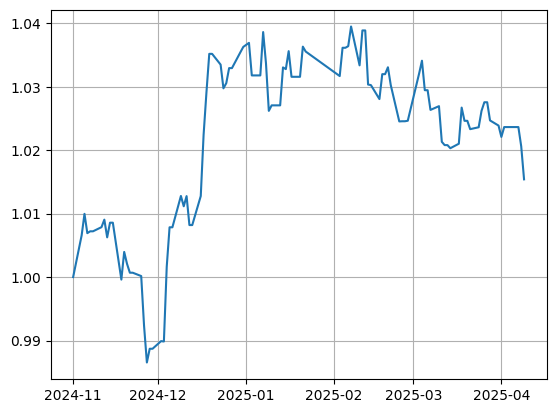

In [245]:
plt.plot(sorted_dates, 1+np.array(return_list))
#plt.title("累積報酬曲線")
#plt.xlabel("期數")
#plt.ylabel("累積報酬")
plt.grid(True)
plt.show()

In [220]:
import psutil

mem = psutil.virtual_memory()

total_MB = mem.total / 1024 / 1024
available_MB = mem.available / 1024 / 1024

print(f"✅ 系統總記憶體: {total_MB:.2f} MB")
print(f"🟢 當前可用記憶體: {available_MB:.2f} MB")


✅ 系統總記憶體: 65298.48 MB
🟢 當前可用記憶體: 48551.12 MB


In [97]:
!nvidia-smi

Thu May 29 15:32:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 36%   29C    P8             N/A /  115W |    4252MiB /   8188MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----